Citation: Richardson G, Knudby A, Chen W, Sawada M, Lovitt J, He L, et al. (2023) Dense neural network outperforms other machine learning models for scaling-up lichen cover maps in Eastern Canada. PLoS ONE 18(11): e0292839. https://doi.org/10.1371/journal.pone.0292839

In [2]:
import numpy as np 
from pathlib import Path
import random
import os, shutil, time, csv,math
from os import walk
import cv2
import matplotlib.pyplot as plt

## Variables

In [3]:
#Full Image Folder Path
FILP = r'D:\Training_Data_Creation\Full_Images'
#Training Creation folders
TCF=r'D:\Training_Data_Creation'
Train_Val_folder_name = 'Train_Val_Test_Mega'
#list of sisite_list
site_list=[]
#list of band combs
bandcombs=['123','456','789','m']
#Megatie height,width -- MUST BE SQUARE
Tilesize=[40,40]
#nodata value
NDV = [255, 255, 255]
#Training Test Validation data split values
TTVS=[.6,.2,.2]


In [4]:
#Load 2019 Data
site_list.extend(['A6','B7','C1','C6','C7','C8','D2','D3','D9','D15','D16'])
#Load 2022 Data
site_list.extend(['S1','S4','S6','S7','S9','S13','S18','S19','S20'])

## For definied datasets using txt files

### Validator to make sure both Sen2 images and masks have same number of NDV pixels. Do before processing.

In [7]:
for i in site_list:
    img= cv2.imread(r'D:\Training_Data_Creation\Full_Images\{}_789.png'.format(i),3)
    maskrgb= cv2.imread(r'D:\Training_Data_Creation\Full_Images\{}_m.png'.format(i),3)
    img_result = np.count_nonzero(np.all(img==[0,0,0],axis=2))
    mask_result = np.count_nonzero(np.all(maskrgb==NDV,axis=2))
    if img_result != mask_result:
        print('Error on {}, img{} mask{}'.format(i,img_result,mask_result))
print('Check complete')

Check complete


In [9]:
def make_megatile(bandcomb,parent_dir):
    Target_full_img = FILP+ "\\{}_{}.png".format(IFP,bandcomb)
    output_folder=TCF+"\\{}\\Megatiles_{}\\".format(parent_dir,bandcomb)
    if Path(output_folder).exists()==False:
        os.makedirs(output_folder)    #creates a folder if it doesnt exist
    TL=[]
    img= cv2.imread(Target_full_img,3) #read image 3 menas read the image in full even if it is 16bit
    Y,X,b= img.shape
    if Y<=30 or X<=30: #for smaller surveys which shouldnt be split due to autocorrleation 
        y=math.ceil(Y/Tilesize[0])*Tilesize[0]-Y #finding what is missing in order to make it 30x30
        x=math.ceil(X/Tilesize[1])*Tilesize[1]-X
        if x>0 or y>0:
            if bandcomb=='m':
                img = cv2.copyMakeBorder(img, 0, y, 0, x, cv2.BORDER_CONSTANT, value=NDV) 
            else:
                img = cv2.copyMakeBorder(img, 0, y, 0, x, cv2.BORDER_CONSTANT, value=[0,0,0])#create no data borders around sen2 imagery
        tile_name="mega_{}_{}".format(IFP,'full')
        img_path=output_folder + tile_name + ".png"
        TL.append(tile_name)
        cv2.imwrite(img_path, img)
    else:    #for larger images
        midx,midy=int(X/2),int(Y/2) #finding the middle and splitting the image in to quarters
        im1=img[0:midy,0:midx]
        im2=img[midy:Y,0:midx]
        im3=img[0:midy,midx:X]
        im4=img[midy:Y,midx:X]
        imlist=[im1,im2,im3,im4]
        for i in range(len(imlist)):
            Y,X,b= imlist[i].shape
            y=math.ceil(Y/Tilesize[0])*Tilesize[0]-Y
            x=math.ceil(X/Tilesize[1])*Tilesize[1]-X
            if x>0 or y>0:
                if bandcomb=='m':
                    img = cv2.copyMakeBorder(imlist[i], 0, y, 0, x, cv2.BORDER_CONSTANT, value=NDV)
                else:
                    img = cv2.copyMakeBorder(imlist[i], 0, y, 0, x, cv2.BORDER_CONSTANT, value=[0,0,0]) #create no data borders around the quarter images
            tile_name="mega_{}_{}".format(IFP,str(i))
            img_path=output_folder + tile_name + ".png"
            TL.append(tile_name)
            cv2.imwrite(img_path, img)

## Defining Functions

In [10]:
def TTV_data_split_make_new_dir(folder,bandcomb):
    tile_list=os.listdir(folder)
    list_len=len(os.listdir(folder))
    List_split_value_train=int(list_len*TTVS[0])
    List_split_value_val=int(list_len*TTVS[0])+int(list_len*TTVS[1])
    random.seed(4)
    all_list=random.sample(tile_list,list_len)#list of all imgs randomly ordered
    Train_list=all_list[:List_split_value_train]#subsetting large list for just training imgs
    Val_list=all_list[List_split_value_train:List_split_value_val]
    Test_list=all_list[List_split_value_val:]
    train_dest=TCF+"\\Train_Mega_{}\\Megatiles_{}\\".format(Tilesize[0],bandcomb) #list of destination dirs
    val_dest=TCF+"\\Val_Mega_{}\\Megatiles_{}\\".format(Tilesize[0],bandcomb)
    test_dest=TCF+"\\Test_Mega_{}\\Megatiles_{}\\".format(Tilesize[0],bandcomb)
    for i in [train_dest,val_dest,test_dest]:
        if Path(i).exists()==False:
            os.makedirs(i)
    for f in Train_list:#moving the tiles into the proper dirs
        shutil.copy(folder+'//'+f, train_dest)
    for g in Val_list:
        shutil.copy(folder+'//'+g, val_dest)
    for h in Test_list:
        shutil.copy(folder+'//'+h, test_dest)

## Process Data

##### Method for Test data amoung rest of data random

In [11]:
for i in ['Train','Val','Test']:
    dataset_path=TCF+'\\{}_Mega_{}\\'.format(i,Tilesize[0])
    #remake folder if it exists or just make the folder
    if Path(dataset_path).exists()==False:
            os.makedirs(dataset_path)
    shutil.rmtree(dataset_path)
    os.makedirs(dataset_path)
for site in site_list:
    IFP=site
    #make megatiles from the sites
    for bandcomb in bandcombs:
        make_megatile(bandcomb,Train_Val_folder_name)
for bandcomb in bandcombs:
    folder_path= TCF+'\\'+Train_Val_folder_name+'\\'+'Megatiles_{}\\'.format(bandcomb)
    #split the data from the directory of megatiles
    TTV_data_split_make_new_dir(folder_path, bandcomb)

#### Validator to make sure both megatiles and masks have same number of NDV pixels. Do before processing.

In [12]:
tile_list=os.listdir('D:\Training_Data_Creation\Train_Val_Test_Mega\Megatiles_123')
for i in tile_list:
    img= cv2.imread(r'D:\Training_Data_Creation\Train_Val_Test_Mega\Megatiles_123\{}'.format(i),3)
    maskrgb= cv2.imread(r'D:\Training_Data_Creation\Train_Val_Test_Mega\Megatiles_m\{}'.format(i),3)
    img_result = np.count_nonzero(np.all(img==[0,0,0],axis=2))
    mask_result = np.count_nonzero(np.all(maskrgb==NDV,axis=2))
    if img_result != mask_result:
        print('Error on {}, img{} mask{}'.format(i,img_result,mask_result))
print('Check complete')

Check complete


##### Method for creating megatile folders from lists of txt

In [1]:
'''See Example Dset Def if you are interested in this'''
train_txt=r'D:\Training_Data_Creation\Pointer_files\Dset_def\Train.txt'
val_txt=r'D:\Training_Data_Creation\Pointer_files\Dset_def\Val.txt'
test_txt=r'D:\Training_Data_Creation\Pointer_files\Dset_def\Test.txt'

In [14]:
'''These txt lists should be made in advanced and found in D:\Training_Data_Creation\Dataset_txt_files '''
def txt_to_list(filename):
    '''HAVE AN EMPTY LINE AFTER LAST LINE IN TXT FILE IN ORDER TO WORK'''
    img_list = []
    with open(filename, 'r') as File:
        infoFile = File.readlines() #Reading all the lines from File
        for line in infoFile: #Reading line-by-line
            img_list.append(line[:-1])
    return img_list
def TTV_data_split_from_txt(folder,bandcomb):
    #creating the image lists from txt files
    Train_list,Val_list,Test_list=txt_to_list(train_txt),txt_to_list(val_txt),txt_to_list(test_txt)
    #announcing the destination paths
    train_dest=TCF+"\\Train_Mega_{}\\Megatiles_{}\\".format(Tilesize[0],bandcomb)
    val_dest=TCF+"\\Val_Mega_{}\\Megatiles_{}\\".format(Tilesize[0],bandcomb)
    test_dest=TCF+"\\Test_Mega_{}\\Megatiles_{}\\".format(Tilesize[0],bandcomb)
    #remaking the folders if they exist, or creating them
    for j in [train_dest,val_dest,test_dest]:
        if Path(j).exists()==False:
                os.makedirs(j)
        shutil.rmtree(j)
        os.makedirs(j)
    #moving the tiles into the proper dirs
    for f in Train_list:
        shutil.copy(folder+'\\'+f, train_dest)
    for g in Val_list:
        shutil.copy(folder+'\\'+g, val_dest)
    for h in Test_list:
        shutil.copy(folder+'\\'+h, test_dest)

In [15]:
for bandcomb in bandcombs:
    folder_path= TCF+'\\'+Train_Val_folder_name+'\\'+'Megatiles_{}'.format(bandcomb)
    TTV_data_split_from_txt(folder_path, bandcomb)
print('done')

done


## Method for seperated test sites

In [ ]:
#where do you want the lichen class to be defined as
TVS=.7

In [ ]:
def TV_data_split_make_new_dir(folder,bandcomb):
    '''This function splits the data according to a spit value (TVS) and assigns megatiles to the respective folders'''
    #create list of files, also len of list, and determining where the cutoff is
    tile_list=os.listdir(folder)
    list_len=len(os.listdir(folder))
    List_split_value=int(list_len*TVS)
    # Using a random seed, creating a randomized list of all tile names
    random.seed(1)
    all_list=random.sample(tile_list,list_len)
    #splitting the tiles according to the randomized list
    Train_list=all_list[:List_split_value]
    Val_list=all_list[List_split_value:]
    #defining the destination folders for where to define training and val mega tiles
    train_dest=TCF+"\\Train_Mega_{}\\Megatiles_{}\\".format(Tilesize[0],bandcomb)
    val_dest=TCF+"\\Val_Mega_{}\\Megatiles_{}\\".format(Tilesize[0],bandcomb)
    #making those Dirs if they do not exist
    if Path(train_dest).exists()==False:
        os.makedirs(train_dest)
    if Path(val_dest).exists()==False:
        os.makedirs(val_dest)
    #moving the tiles into the proper dirs
    for f in Train_list:
        shutil.move(folder+'//'+f, train_dest)
    for g in Val_list:
        shutil.move(folder+'//'+g, val_dest)

In [13]:
#creates megatile folders or deletes existing megatile folders
for i in ['Train','Val','Test']:
    dataset_path=TCF+'\\{}_Mega_{}\\'.format(i,Tilesize[0])
    if Path(dataset_path).exists()==False:
            os.makedirs(dataset_path)
    shutil.rmtree(dataset_path)
    os.makedirs(dataset_path)
train_val_sites=site_list.copy()
for site in Test_site_list:
    #seperating sites defined as test sites from the rest
    train_val_sites.remove(str(site))
    IFP=site
    #processing the test megatiles and putting them all in a folder
    for bandcomb in bandcombs:
        #creates megatile folders for both test sets together, and also for individual test sites
        make_megatile(bandcomb,'Test_Mega_{}'.format(Tilesize[0]))
        make_megatile(bandcomb,'Test-{}_Mega_{}'.format(site,Tilesize[0]))
#Processing all training/validation data and putting it in a single folder
print('{} are for training and validation'.format(train_val_sites))
for site in train_val_sites:
    IFP=site
    for bandcomb in bandcombs:
        make_megatile(bandcomb,Train_Val_folder_name)
#splitting the training/validation mega tiles and putting them in their respective folder
for bandcomb in bandcombs:
    folder_path= TCF+'\\'+Train_Val_folder_name+'\\'+'Megatiles_{}\\'.format(bandcomb)
    TV_data_split_make_new_dir(folder_path, bandcomb)
#deleting temp folder which was used to hold the train/val megatiles together
#shutil.rmtree(TCF+'\\'+Train_Val_folder_name)

['B7', 'C1', 'C6', 'C7', 'D2', 'D3', 'D9', 'D15'] are for training and validation


Shape of the image (67, 69, 3)
lol this needs resizing
34 33
Shape of the image (40, 40, 3)


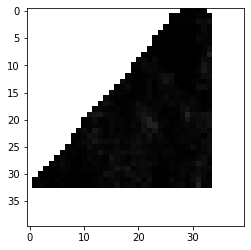

lol this needs resizing
34 33
Shape of the image (40, 40, 3)


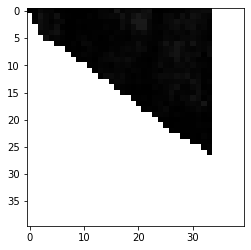

lol this needs resizing
34 33
Shape of the image (40, 40, 3)


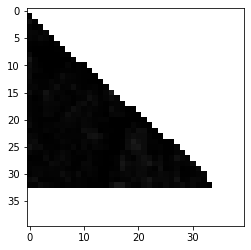

lol this needs resizing
34 33
Shape of the image (40, 40, 3)


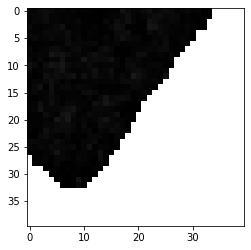

In [15]:
Tilesize=[40,40]
img= cv2.imread(r'D:\Training_Data_Creation\Full_Images\C6_m.png',3)
img_shape=img.shape
Y,X,b= img.shape
print("Shape of the image", img_shape)
midx,midy=int(img_shape[1]/2),int(img_shape[0]/2)
imlist=[im1,im2,im3,im4]
im1=img[0:midy,0:midx]
im2=img[midy:Y,0:midx]
im3=img[0:midy,midx:X]
im4=img[midy:Y,midx:X]
for i in imlist:
    Y,X,b= i.shape
    y=math.ceil(Y/Tilesize[0])*Tilesize[0]-Y
    x=math.ceil(X/Tilesize[1])*Tilesize[1]-X
    if x>0 or y>0:
        #print('lol this needs resizing')
        #make white border if it is a mask, 0,0,0 border if it isnt
        if bandcomb=='m':
            img = cv2.copyMakeBorder(i, 0, y, 0, x, cv2.BORDER_CONSTANT, value=NDV)
        else:
            img = cv2.copyMakeBorder(i, 0, y, 0, x, cv2.BORDER_CONSTANT, value=[0,0,0,0])
    print(midx,midy)
    plt.imshow(img)
    print("Shape of the image", img.shape)
    plt.show()